# Neural Networks - Undercomplete Auto Encoder (AE)

### Step 1 - Improt libraries

In [78]:
# Tensorflow / Keras
from tensorflow import keras # for building Neural Networks
print('Tensorflow/Keras: %s' % keras.__version__) # print version
from keras.models import Model, load_model # for creating a Neural Network Autoencoder model
from keras import Input # for instantiating a keras tensor
from keras.layers import Dense, LeakyReLU, BatchNormalization # for adding layers to AE model
from tensorflow.keras.utils import plot_model # for plotting model diagram


# Data manipulation
import pandas as pd # for data manipulation
print('pandas: %s' % pd.__version__) # print version


# Sklearn
import sklearn # for model evaluation
print('sklearn: %s' % sklearn.__version__) # print version
from sklearn.preprocessing import MinMaxScaler # for rescaling metrics to fit into 0 to 1 range
from sklearn.model_selection import train_test_split # for splitting the data into train and test samples
from sklearn.linear_model import LogisticRegression # for building logistic regression models
from sklearn.metrics import classification_report # for model evaluation metrics


# Visualization
import matplotlib 
import matplotlib.pyplot as plt # for plotting model loss
print('matplotlib: %s' % matplotlib.__version__) # print version
import graphviz # for showing model diagram
print('graphviz: %s' % graphviz.__version__) # print version


# Other utilities
import sys
import os

# Assign main directory to a variable
main_dir=os.path.dirname(sys.path[0])
#print(main_dir)

Tensorflow/Keras: 2.7.0
pandas: 1.3.4
sklearn: 1.0.1
matplotlib: 3.5.1
graphviz: 0.19.1


### Step 2 - Get the weather data for our model (from Kaggle)
- Donwload from: https://www.kaggle.com/jsphyg/weather-dataset-rattle-package
- After downloading it, we read csv into a Pandas dataframe

In [60]:
# Set Pandas options to display more columns
pd.options.display.max_columns=50

# Read in the weather data csv
df=pd.read_csv(main_dir+'/data/weatherAUS.csv', encoding='utf-8')

# Drop records where target RainTomorrow=NaN
#df=df[pd.isnull(df['RainTomorrow'])==False]

# Drop rows where any of the values are missing. 
# Note, in this case it drops ~60% of the rows. Since we are using this data just as an example, it's ok.
# However, when you work with your own data, you may want to explore other options to fill in NA's with, say, mean values
df=df.dropna(axis=0)

# Create a flag for RainToday and RainTomorrow, note RainTomorrowFlag will be our target variable
df['RainTodayFlag']=df['RainToday'].apply(lambda x: 1 if x=='Yes' else 0)
df['RainTomorrowFlag']=df['RainTomorrow'].apply(lambda x: 1 if x=='Yes' else 0)

# Show a snaphsot of data
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainTodayFlag,RainTomorrowFlag
6049,2009-01-01,Cobar,17.9,35.2,0.0,12.0,12.3,SSW,48.0,ENE,SW,6.0,20.0,20.0,13.0,1006.3,1004.4,2.0,5.0,26.6,33.4,No,No,0,0
6050,2009-01-02,Cobar,18.4,28.9,0.0,14.8,13.0,S,37.0,SSE,SSE,19.0,19.0,30.0,8.0,1012.9,1012.1,1.0,1.0,20.3,27.0,No,No,0,0
6052,2009-01-04,Cobar,19.4,37.6,0.0,10.8,10.6,NNE,46.0,NNE,NNW,30.0,15.0,42.0,22.0,1012.3,1009.2,1.0,6.0,28.7,34.9,No,No,0,0
6053,2009-01-05,Cobar,21.9,38.4,0.0,11.4,12.2,WNW,31.0,WNW,WSW,6.0,6.0,37.0,22.0,1012.7,1009.1,1.0,5.0,29.1,35.6,No,No,0,0
6054,2009-01-06,Cobar,24.2,41.0,0.0,11.2,8.4,WNW,35.0,NW,WNW,17.0,13.0,19.0,15.0,1010.7,1007.4,1.0,6.0,33.6,37.6,No,No,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142298,2017-06-20,Darwin,19.3,33.4,0.0,6.0,11.0,ENE,35.0,SE,NE,9.0,20.0,63.0,32.0,1013.9,1010.5,0.0,1.0,24.5,32.3,No,No,0,0
142299,2017-06-21,Darwin,21.2,32.6,0.0,7.6,8.6,E,37.0,SE,SE,13.0,11.0,56.0,28.0,1014.6,1011.2,7.0,0.0,24.8,32.0,No,No,0,0
142300,2017-06-22,Darwin,20.7,32.8,0.0,5.6,11.0,E,33.0,E,W,17.0,11.0,46.0,23.0,1015.3,1011.8,0.0,0.0,24.8,32.1,No,No,0,0
142301,2017-06-23,Darwin,19.5,31.8,0.0,6.2,10.6,ESE,26.0,SE,NNW,9.0,17.0,62.0,58.0,1014.9,1010.7,1.0,1.0,24.8,29.2,No,No,0,0


In [68]:
# Select data for modeling
X=df[['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 
      'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am',  
      'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainTodayFlag']]
y=df['RainTomorrowFlag'].values

# Scale training data so it is between 0 and 1
scaler = MinMaxScaler()
X_scaled=scaler.fit_transform(X)

# Create training and testing samples
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0)
#X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=0)

### Step 3 - Build an Undercomplete Autoencoder model

Model: "Autoencoder-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input-Layer (InputLayer)    [(None, 17)]              0         
                                                                 
 Encoder-Layer (Dense)       (None, 17)                306       
                                                                 
 Encoder-Layer-Normalization  (None, 17)               68        
  (BatchNormalization)                                           
                                                                 
 Encoder-Layer-Activation (L  (None, 17)               0         
 eakyReLU)                                                       
                                                                 
 Bottleneck-Layer (Dense)    (None, 8)                 144       
                                                                 
 Decoder-Layer (Dense)       (None, 17)          

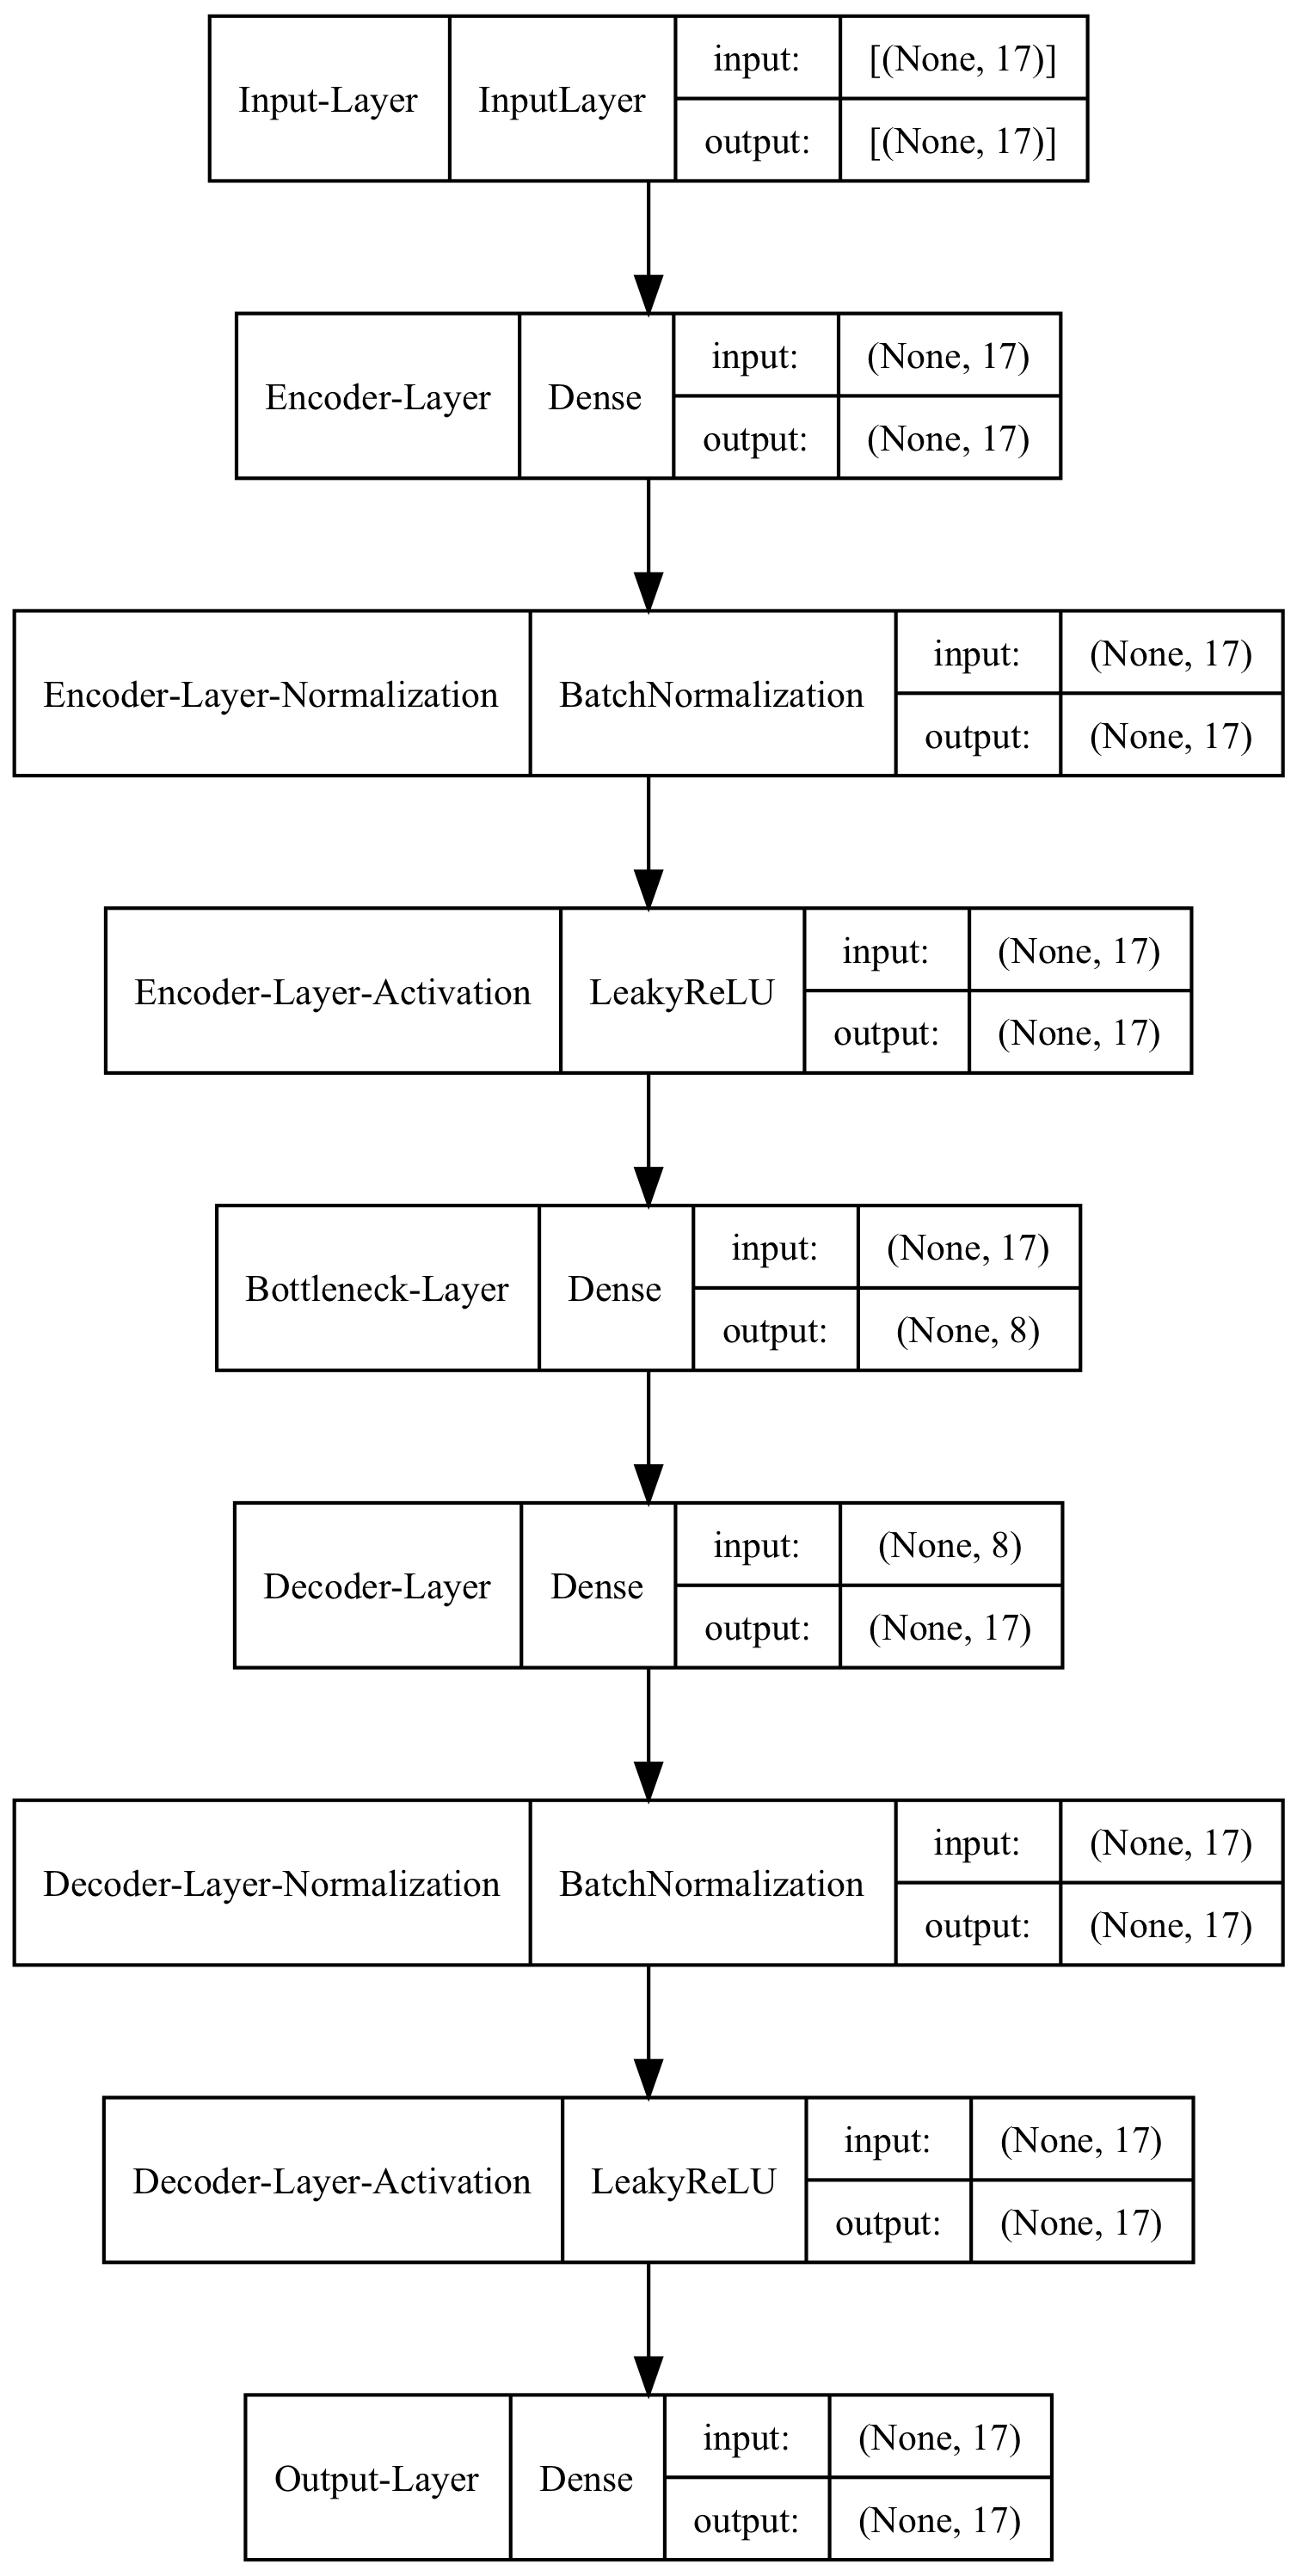

In [53]:
#--- Define Shapes
n_inputs=X_train.shape[1] # number of input neurons = the number of features X_train
n_bottleneck=(round(float(n_inputs) / 2.0)) # bottleneck to have half the number of neurons 

#--- Input Layer 
visible = Input(shape=(n_inputs,), name='Input-Layer') # Specify input shape

#--- Encoder Layer
e = Dense(units=n_inputs, name='Encoder-Layer')(visible)
e = BatchNormalization(name='Encoder-Layer-Normalization')(e)
e = LeakyReLU(name='Encoder-Layer-Activation')(e)

#--- Bottleneck
bottleneck = Dense(units=n_bottleneck, name='Bottleneck-Layer')(e)

#--- Decoder Layer
d = Dense(units=n_inputs, name='Decoder-Layer')(bottleneck)
d = BatchNormalization(name='Decoder-Layer-Normalization')(d)
d = LeakyReLU(name='Decoder-Layer-Activation')(d)

#--- Output layer
output = Dense(units=n_inputs, activation='linear', name='Output-Layer')(d)

# Define autoencoder model
model = Model(inputs=visible, outputs=output, name='Autoencoder-Model')

# Compile autoencoder model
model.compile(optimizer='adam', loss='mse')

# Print model summary
print(model.summary())

# Plot the autoencoder model diagram
plot_model(model, to_file=main_dir+'/pics/Autoencoder.png', show_shapes=True, dpi=300)

##### Train the model

In [54]:
# Fit the autoencoder model to reconstruct input
history = model.fit(X_train, X_train, epochs=10, batch_size=16, verbose=1, validation_data=(X_test, X_test))

Epoch 1/10
2821/2821 [==============================] - 5s 1ms/step - loss: 0.0307 - val_loss: 0.0048
Epoch 2/10
2821/2821 [==============================] - 4s 1ms/step - loss: 0.0073 - val_loss: 0.0029
Epoch 3/10
2821/2821 [==============================] - 4s 1ms/step - loss: 0.0059 - val_loss: 0.0025
Epoch 4/10
2821/2821 [==============================] - 4s 1ms/step - loss: 0.0050 - val_loss: 0.0020
Epoch 5/10
2821/2821 [==============================] - 4s 1ms/step - loss: 0.0045 - val_loss: 0.0018
Epoch 6/10
2821/2821 [==============================] - 4s 1ms/step - loss: 0.0043 - val_loss: 0.0017
Epoch 7/10
2821/2821 [==============================] - 4s 2ms/step - loss: 0.0041 - val_loss: 0.0017
Epoch 8/10
2821/2821 [==============================] - 4s 1ms/step - loss: 0.0040 - val_loss: 0.0015
Epoch 9/10
2821/2821 [==============================] - 4s 2ms/step - loss: 0.0038 - val_loss: 0.0016
Epoch 10/10
2821/2821 [==============================] - 4s 1ms/step - loss: 0.003

##### Plot loss

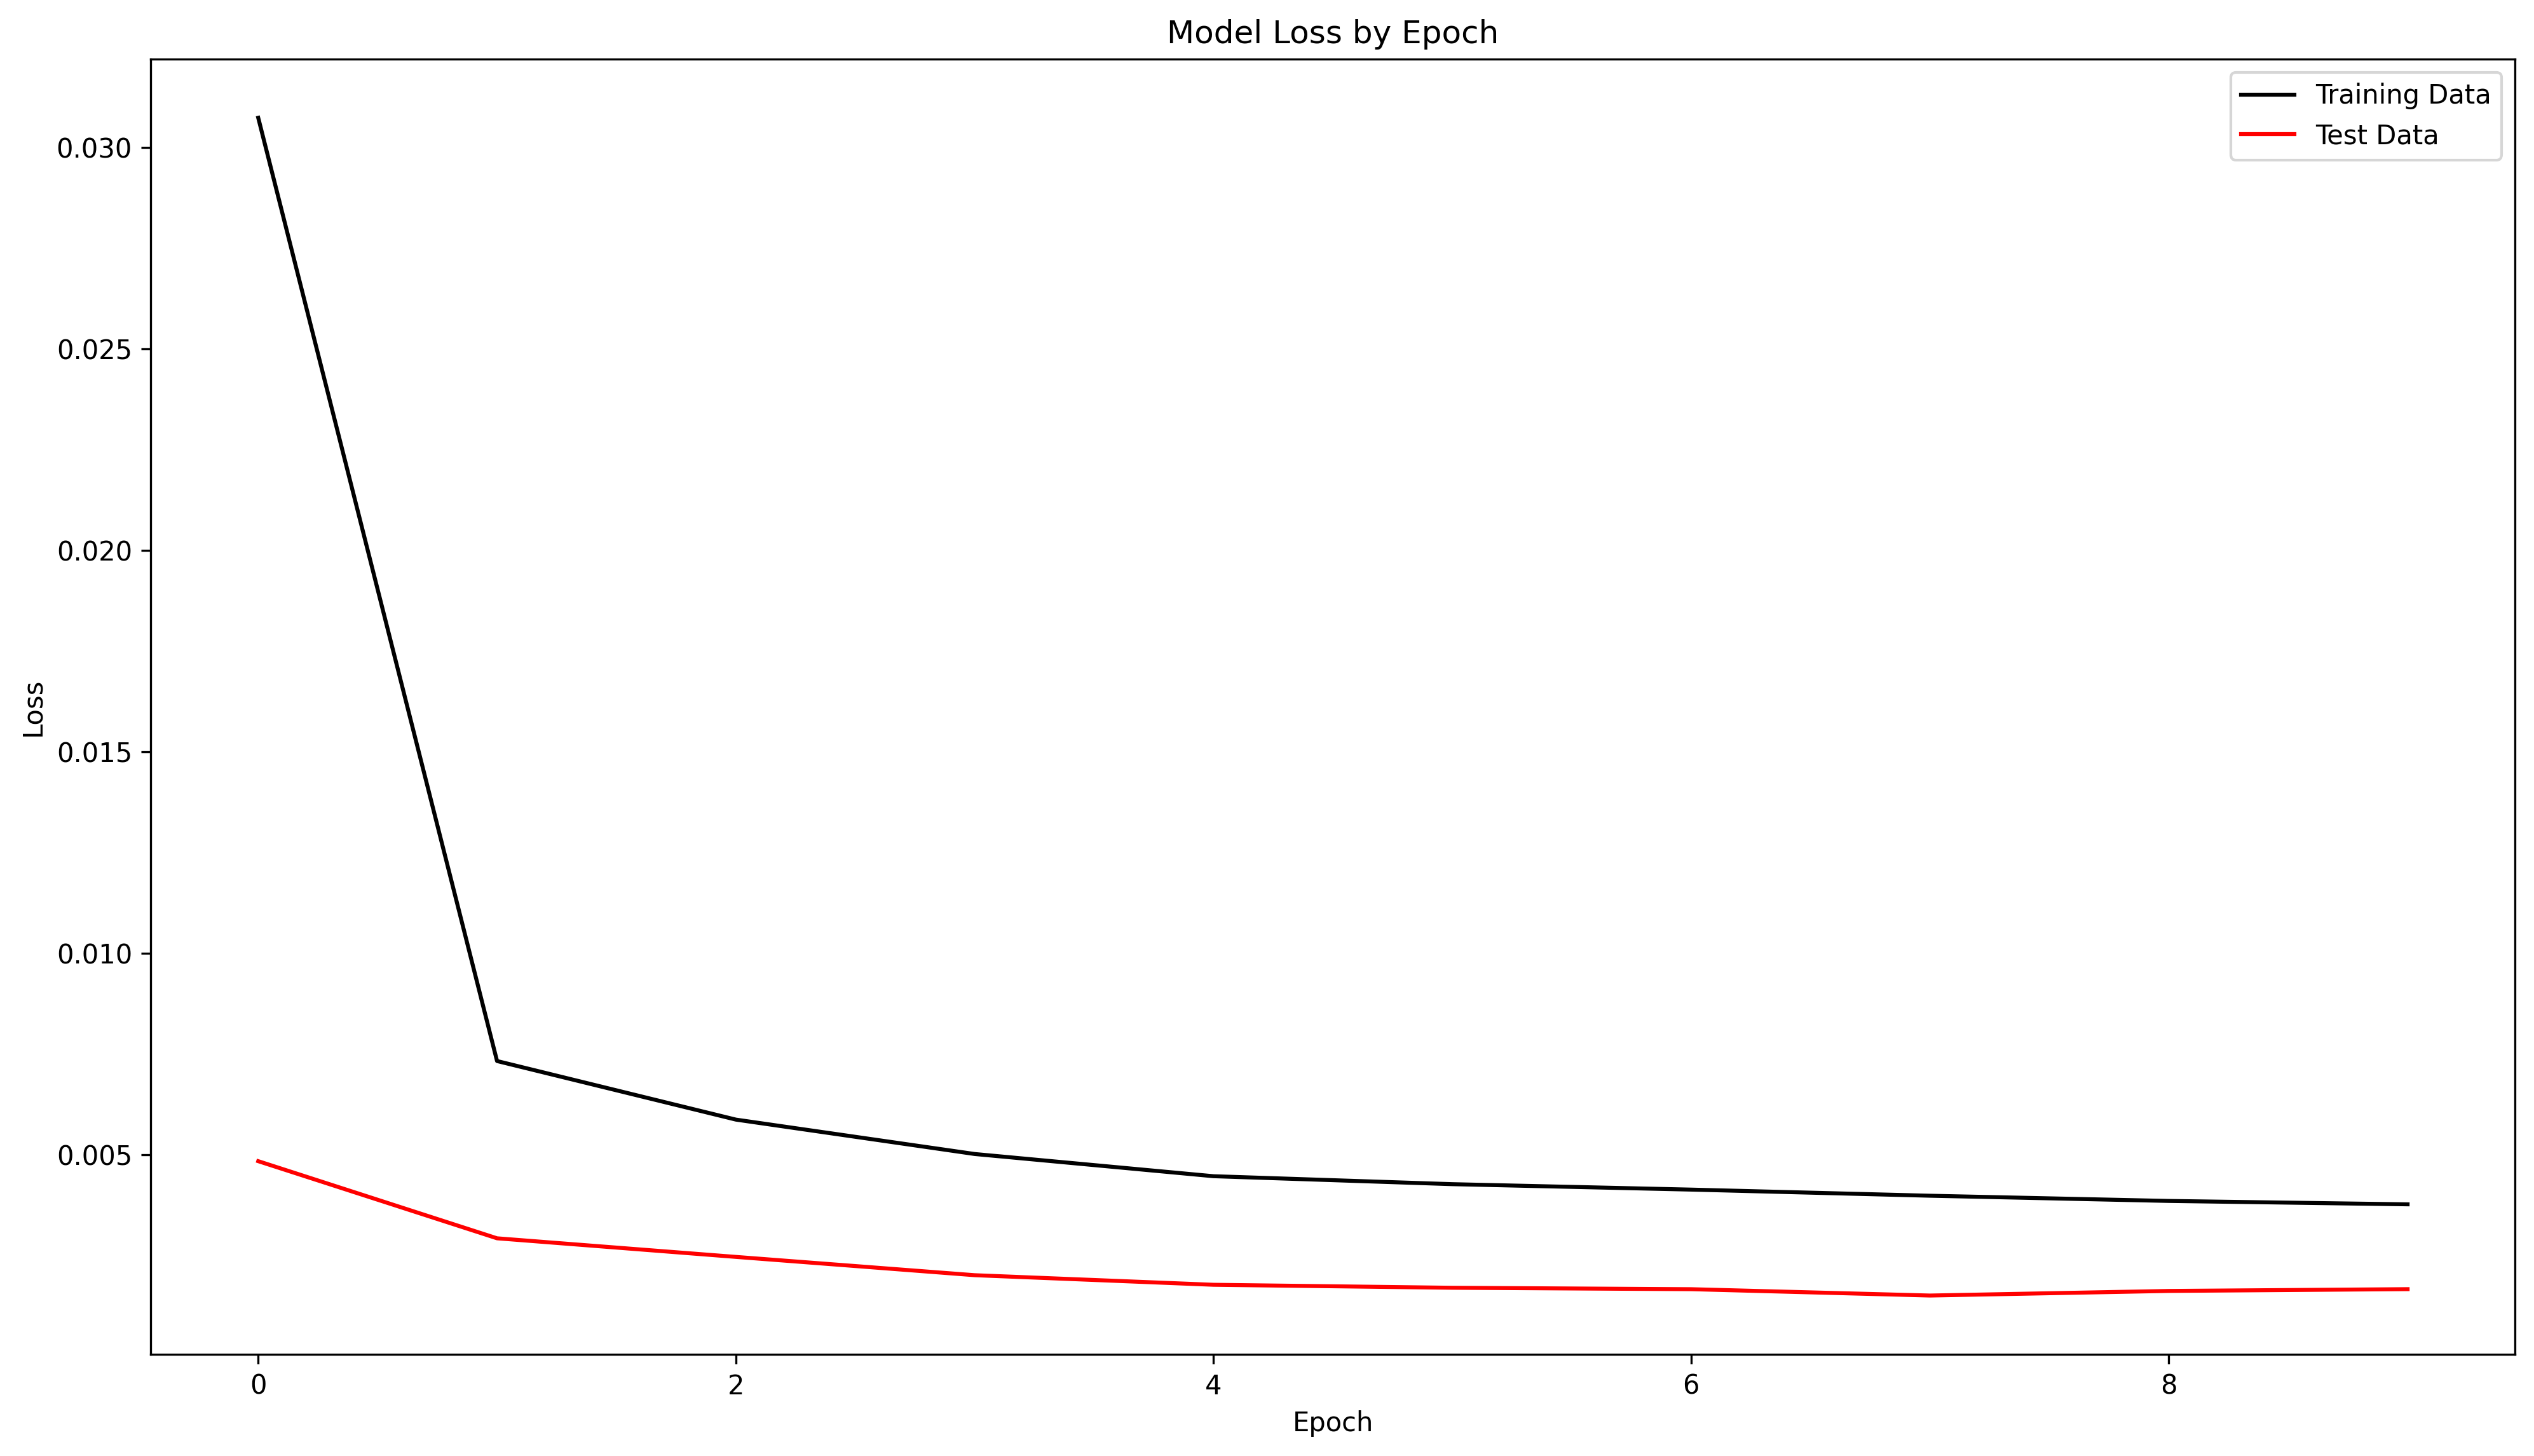

In [55]:
# Plot a loss chart
fig, ax = plt.subplots(figsize=(16,9), dpi=300)
plt.title(label='Model Loss by Epoch', loc='center')

ax.plot(history.history['loss'], label='Training Data', color='black')
ax.plot(history.history['val_loss'], label='Test Data', color='red')
ax.set(xlabel='Epoch', ylabel='Loss')
plt.legend()

plt.show()

##### Save only the encoder part of the model and plot its diagram

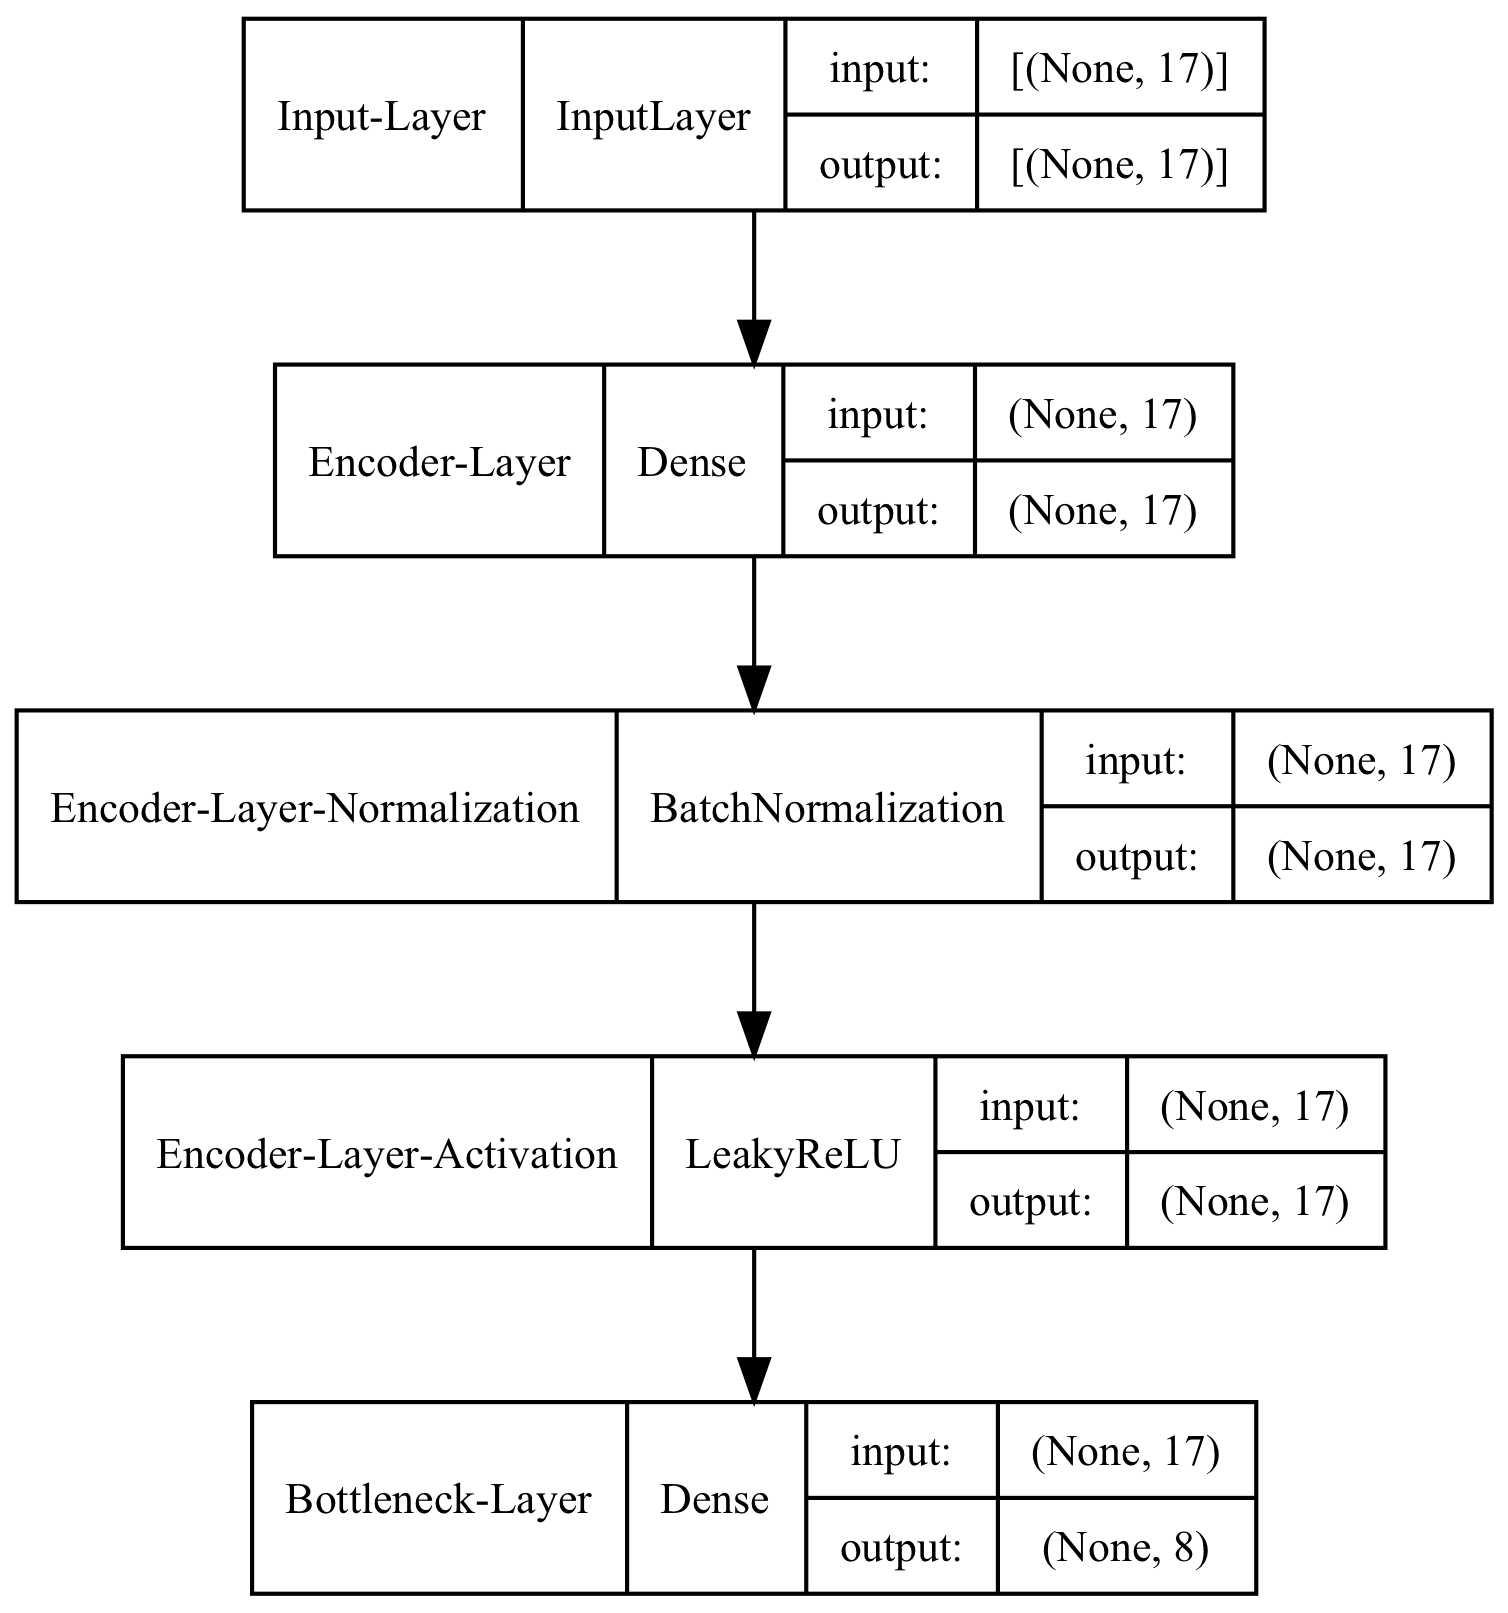

In [56]:
# Define an encoder model without the decoder
encoder = Model(inputs=visible, outputs=bottleneck)

# Compile encoder model
encoder.compile(optimizer='adam', loss='mse')

# Save the encoder model to file
encoder.save(main_dir+'/data/encoder.h5')

# Plot the autoencoder model diagram
plot_model(encoder, to_file=main_dir+'/pics/Encoder_only.png', show_shapes=True, dpi=300)

### Step 4 - Build two Logistic Regression Models to Predict Tomorrow's Rain Probability

###### Baseline - Without Autoencoder

In [57]:
# ----- Without Autoencoder -----

# Fit the model
model1 = LogisticRegression(solver='sag')
clf1 = model1.fit(X_train, y_train)

# Predict class labels on train and test data
pred_labels_tr1 = model1.predict(X_train)
pred_labels_te1 = model1.predict(X_test)


print('****************** Summary ******************')
# Print slope and intercept
print('Intercept (Beta 0): ', clf1.intercept_)
print('Slope (Beta 1): ', clf1.coef_)
print('--------------------------------------------------------')
print("")

print('*************** Evaluation on Test Data ***************')
score_te1 = model1.score(X_test, y_test)
print('Accuracy Score: ', score_te1)
# Look at classification report to evaluate the model
print(classification_report(y_test, pred_labels_te1))
print('--------------------------------------------------------')
print("")

print('*************** Evaluation on Training Data ***************')
score_tr1 = model1.score(X_train, y_train)
print('Accuracy Score: ', score_tr1)
# Look at classification report to evaluate the model
print(classification_report(y_train, pred_labels_tr1))
print('--------------------------------------------------------')

****************** Summary ******************
Intercept (Beta 0):  [-3.09233125]
Slope (Beta 1):  [[-1.64344579  0.41380331  1.72542657 -0.31660108 -2.19233614  6.40991096
  -0.95222154 -1.77095125  0.1281439   5.61043909  4.31760627 -8.19114823
  -0.18663071  1.02659946  0.77086822  1.128728    0.45933578]]
--------------------------------------------------------

*************** Evaluation on Test Data ***************
Accuracy Score:  0.859181141439206
              precision    recall  f1-score   support

           0       0.89      0.94      0.91      8854
           1       0.72      0.56      0.63      2430

    accuracy                           0.86     11284
   macro avg       0.81      0.75      0.77     11284
weighted avg       0.85      0.86      0.85     11284

--------------------------------------------------------

*************** Evaluation on Training Data ***************
Accuracy Score:  0.8526896490606168
              precision    recall  f1-score   support

     

##### With Autoencoder

In [59]:
# ----- With Autoencoder -----
# Load the model from file
encoder = load_model(main_dir+'/data/encoder.h5')

# Encode train and test data
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)


# Fit the model
model2 = LogisticRegression(solver='sag')
clf2 = model2.fit(X_train_encoded, y_train)

# Predict class labels on train and test data
pred_labels_tr2 = model2.predict(X_train_encoded)
pred_labels_te2 = model2.predict(X_test_encoded)


print('****************** Summary ******************')
# Print slope and intercept
print('Intercept (Beta 0): ', clf2.intercept_)
print('Slope (Beta 1): ', clf2.coef_)
print('--------------------------------------------------------')
print("")

print('*************** Evaluation on Test Data ***************')
score_te2 = model2.score(X_test_encoded, y_test)
print('Accuracy Score: ', score_te2)
# Look at classification report to evaluate the model
print(classification_report(y_test, pred_labels_te2))
print('--------------------------------------------------------')
print("")

print('*************** Evaluation on Training Data ***************')
score_tr2 = model2.score(X_train_encoded, y_train)
print('Accuracy Score: ', score_tr2)
# Look at classification report to evaluate the model
print(classification_report(y_train, pred_labels_tr2))
print('--------------------------------------------------------')

****************** Summary ******************
Intercept (Beta 0):  [-2.9643567]
Slope (Beta 1):  [[2.408258   0.9912143  0.2586915  2.1948953  0.8568974  3.0200946
  0.42147934 2.5099342 ]]
--------------------------------------------------------

*************** Evaluation on Test Data ***************
Accuracy Score:  0.8491669620701878
              precision    recall  f1-score   support

           0       0.87      0.94      0.91      8854
           1       0.71      0.51      0.59      2430

    accuracy                           0.85     11284
   macro avg       0.79      0.72      0.75     11284
weighted avg       0.84      0.85      0.84     11284

--------------------------------------------------------

*************** Evaluation on Training Data ***************
Accuracy Score:  0.8445586671393123
              precision    recall  f1-score   support

           0       0.87      0.94      0.90     35139
           1       0.72      0.49      0.58      9997

    accuracy   

In this case the performance of the molde using encoded features is not as good compared to the original features. This indicates a slight loss in the important information following the encoding of the data. However, the performance loss is minimal.

Nevertheless, one should way pros and cons of using autoencoders within your model pipeline. Sometimes it may be easier to remove highly correlated or less predictive features upfornt instead of trying to encode them.

# End of Program